# Parameter Estimation for ODE Systems using Julia

In [1]:
using DifferentialEquations, Plots, Random
using Optimization, SciMLSensitivity, Zygote, OptimizationOptimJL, LineSearches

In this example, we will reuse a slightly modified version of the homeostatic chemical reaction system from the ODE simulation example. We removed the external input and the sink term of A.

$$
\begin{align}
\dot{A} &= \frac{p_1}{1+C} - k_1A \\
\dot{B} &= k_1A - k_2B \\
\dot{C} &= \frac{k_2B}{1+C} - c_1C  \\
\end{align}
$$

In [2]:
function chemsys!(du, u, p, t)
    A, B, C = u
    p1, k1, k2, c1 = p
    du[1] = ((p1)./(1 .+C)) .- k1.*A
    du[2] = k1.*A .- k2.*B
    du[3] = (k2.*B)./(1 .+C) - c1.*C
end;

# parameters
u0 = [1., 0., 0.]
initial_p = [0.1, 0.15, 0.07, 0.12]
tspan = (0., 500.)

# and create an ode problem to solve
problem = ODEProblem(chemsys!, u0, tspan, initial_p);

As a first example, we will try to obtain a steady state of 0.3 for all three molecules after $t = 200$. At first, we have to define a loss function for optimization.

In [3]:
steady_state_target = 0.3
function loss(p) 
    # save the solution at every second until 500 seconds 
    solution = DifferentialEquations.solve(problem,Tsit5(), p=p, saveat=0:500)

    u = Matrix(solution)

    error = sum(abs2, u[:, 201:end].-steady_state_target)
    return error, solution
end

print("The initial loss is $(loss(initial_p)[1])")

The initial loss is 164.14767806142876

We then define an optimization function. For this we first have to specify which algorithm we want to use for automatic differentiation (AD). Often, the AutoZygote option is a good choice. We then use this to define the OptimizationFunction, which takes a function and the AD type as arguments. The function should be a function of the parameters $x$ and the hyperparameters $p$. Because our loss function has no hyperparameters, we specify an anonymous function where the second argument is not used.

In [4]:
adtype = Optimization.AutoZygote()
optf   = Optimization.OptimizationFunction((x,p) -> loss(x), adtype);

We can also define a small callback function to print the loss function value at every step.

In [5]:
callback = function (p, l, pred)
    display(l)
    # Tell Optimization.solve to not halt the optimization. If return true, then
    # optimization stops.
    return false
end

#3 (generic function with 1 method)

Time to optimize! The solver is taken from the OptimizationOptimJL library, where we choose the BFGS solver. We modify the solver a bit, changing the line search algorithm to 3rd-order backtracking, instead of the default Haeger-Zhang, as this results in less gradient calls and a faster optimization. 

In [6]:
opt_problem = Optimization.OptimizationProblem(optf, initial_p, lb = [0.,0.,0.,0.], ub=[0.2,0.2,0.2,0.2]);
sol     = Optimization.solve(opt_problem, BFGS(linesearch=BackTracking(order=3)), callback=callback)
print(sol)

164.14767806142876

8.628929696959919

1.012988495429312

0.3813293627737939

0.009312621612591733

0.12383013974551432

0.09286105559035818

0.020446391870486785

0.010823036475971276

0.0019482000275467652

0.007713374731865407

0.004430920010651395

0.00023064555634044225

0.00019316776127108087

5.853044156170033e-5

7.027666426839373e-5

6.048392484656009e-5

6.300802896203839e-5

6.26592258573457e-5

6.264105686351314e-5

6.264105707510145e-5

6.264105707510145e-5

6.264105707510145e-5

2.1673123080405674e-5

8.238519406694128e-6

8.233681074061215e-6

7.989632506432393e-6

7.866944282491703e-6

7.227414415402651e-6

7.227414346492821e-6

7.227414346492821e-6

7.227414346492821e-6

7.225301405134327e-6

7.221436506901338e-6

7.221431935535096e-6

7.189711543383637e-6

4.92964363585434e-6

4.304924490344307e-6

4.2072575770736505e-6

4.202610344168322e-6

3.934936645477666e-6

3.926519740938687e-6

3.819168720803012e-6

3.819168713973522e-6

3.3334497146164984e-6

2.7925622925952322e-6

2.785005608158957e-6

2.784795149170753e-6

2.7847915370890567e-6

2.784791513941304e-6

2.7574506940665627e-6

2.757447408265322e-6

2.7574473935006104e-6

2.7571992002381155e-6

2.7570103648326706e-6

2.7569738946132845e-6

2.7569411007974585e-6

2.756940348135074e-6

2.7569403411675007e-6

2.756939814040543e-6

2.756939287410689e-6

2.7569390430712665e-6

2.756938993795915e-6

2.7569388767663804e-6

2.756938868723108e-6

2.756938865250981e-6

2.7569388570893248e-6

2.7569388570893248e-6

2.7569388570893248e-6

2.756938857077448e-6

2.756938857077448e-6

2.756938857077448e-6

2.756938857077448e-6

retcode: Success
u: [0.07511851568652576, 0.1926117908302369, 0.19261143380784781, 0.1481631913117048]
Final objective value:     2.756938857077448e-6


We see that the optimization has succesfully found a solution within our boundaries and we decide to plot the solution.

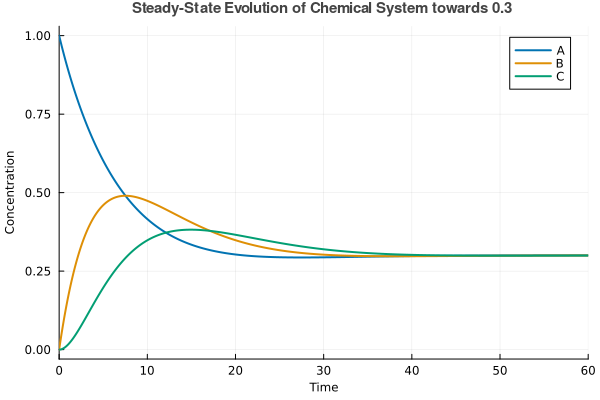

In [7]:
new_system = remake(problem, p = sol.u, tspan=(0.,60.))
new_ode_solution = DifferentialEquations.solve(new_system)
plot(new_ode_solution, linewidth=2, labels=["A" "B" "C"], xlabel="Time", ylabel="Concentration", 
labelfontsize=8, title="Steady-State Evolution of Chemical System towards 0.3", 
titlefontsize = 10, titlefontfamily = "Helvetica Bold", palette=:seaborn_colorblind)

## Data Assimilation
Parameter estimation using data can equally be performed. Observe the dataset below, simulated using the newly learned system. We have learned data on A and C

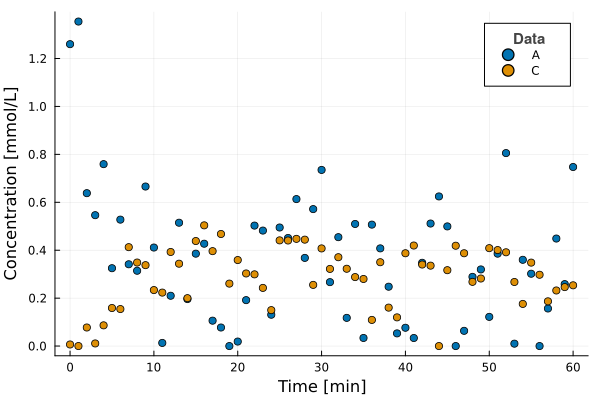

In [8]:
rng = MersenneTwister(313)
data_AC = max.(Matrix(new_ode_solution(0:60, idxs=[1, 3])) .+ randn(rng, (2,61)).*[0.2, 0.12],0)
scatter(0:60, data_AC', labels=["A" "C"], legendtitle="Data", legendtitlefontfamily="Helvetica Bold", legendtitlefontsize=10, xlabel="Time [min]", ylabel = "Concentration [mmol/L]", palette=:seaborn_colorblind)

We can define a loss function based on the external data as well.

In [9]:
# use the same initial parameters as in the first function
initial_p = [0.1, 0.15, 0.07, 0.12]

function get_loss(data, problem::ODEProblem)

    loss = (p) -> begin
    # save the solution at every data point
    solution = DifferentialEquations.solve(problem,Tsit5(), p=p, saveat=0:60)

    error = sum(abs2, Matrix(solution)[[1,3],:].-data)
    return error, solution
    end

    loss
end

loss_func = get_loss(data_AC, new_system)

print("The initial loss is $(loss_func(initial_p)[1])")

The initial loss is 7.046803554529034

Now solve the problem

In [10]:
adtype = Optimization.AutoZygote()
optf   = Optimization.OptimizationFunction((x,p) -> loss_func(x), adtype);

opt_problem = Optimization.OptimizationProblem(optf, initial_p, lb = [0.,0.,0.,0.], ub=[0.5,0.5,0.5,0.5]);
sol     = Optimization.solve(opt_problem, BFGS(linesearch=BackTracking(order=3)),x_tol=1e-12, g_tol=1e-12)
print(sol)

retcode: Success
u: [0.11150318697909525, 0.27567977039879327, 0.15314513550986417, 0.21712246790498146]
Final objective value:     3.551971243352088


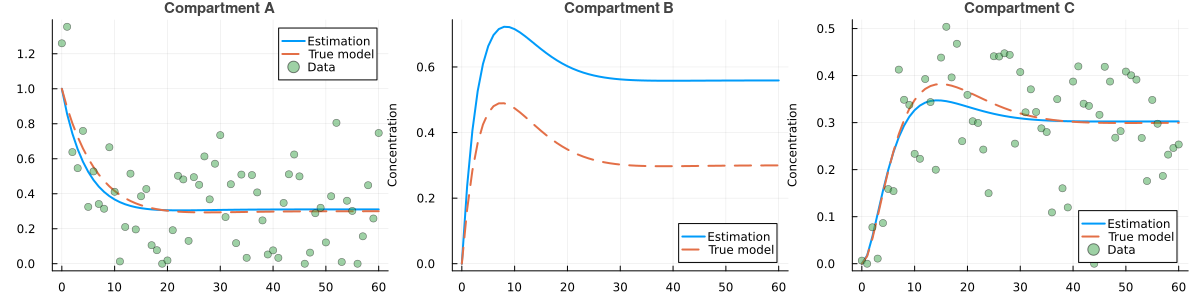

In [11]:
assimilated_system = remake(problem, p = sol.u, tspan=(0.,60.))
assimilated_ode_solution = DifferentialEquations.solve(assimilated_system)

# A
pA = plot(assimilated_ode_solution(0:60, idxs=1), labels="Estimation", title="Compartment A")
plot!(pA, new_ode_solution(0:60, idxs=1), labels="True model", ls=:dash)
scatter!(pA, 0:60, data_AC'[:,1], labels="Data", alpha=0.5)

# B
pB = plot(assimilated_ode_solution(0:60, idxs=2), labels="Estimation", title="Compartment B")
plot!(pB, new_ode_solution(0:60, idxs=2), labels="True model", ls=:dash)

# C
pC = plot(assimilated_ode_solution(0:60, idxs=3), labels="Estimation", title="Compartment C")
plot!(pC, new_ode_solution(0:60, idxs=3), labels="True model", ls=:dash)
scatter!(pC, 0:60, data_AC'[:,2], labels="Data", alpha=0.5)

plot(pA, pB, pC, linewidth=2, xlabel="Time", ylabel="Concentration", 
labelfontsize=8, titlefontsize = 10, titlefontfamily = "Helvetica Bold", layout=(1,3), size=(1200,300), palette=:seaborn_colorblind)

From these plots above, we can see that the model achieves good estimates for compartment A and C, while the compartment lacking data is incorrectly estimated. To see whether all four parameters are identifiable, we can perform an identifiability analysis, which is described in the next tutorial. 